# 02: Geoprocessing


## imports


In [1]:
import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap

# done
# spatial join
# buildings to tax lots
# buildings in 3d with lonboard
# dissolve tax lot by lu or by owner

# not done
# union tax lots and sidewalk to get blocks in total
# intersect to show non-building area
# calculate soft site potential based on FAR, lot size, building class

In [2]:
cb_307 = ogr.read_dataframe(
    "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb", where="CD = 307"
)

In [3]:
cb_307.LandUse

0                        Transportation & Utility
1                      One & Two Family Buildings
2                      One & Two Family Buildings
3                      One & Two Family Buildings
4                                     Vacant Land
                           ...                   
13279    Mixed Residential & Commercial Buildings
13280               Commercial & Office Buildings
13281               Commercial & Office Buildings
13282               Commercial & Office Buildings
13283                    Transportation & Utility
Name: LandUse, Length: 13284, dtype: object

<Axes: >

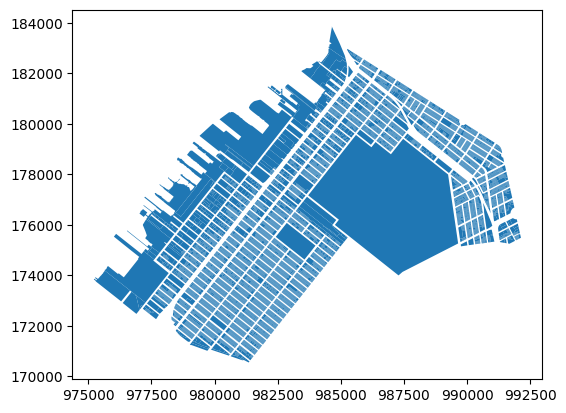

In [4]:
cb_307.plot()

In [5]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [6]:
bounds

array([975222.90192556, 170552.42205763, 992130.25818682, 183853.30228138])

In [7]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

In [8]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

<Axes: >

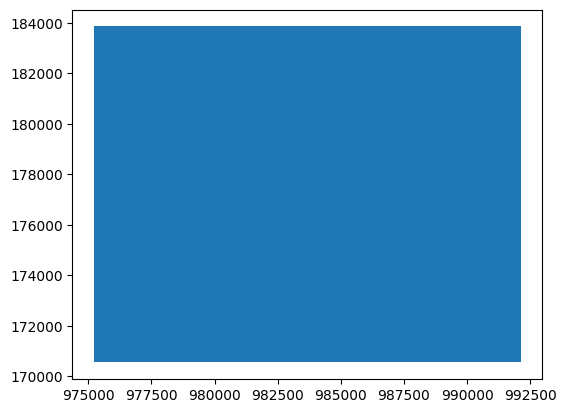

In [9]:
bounds_poly.plot()

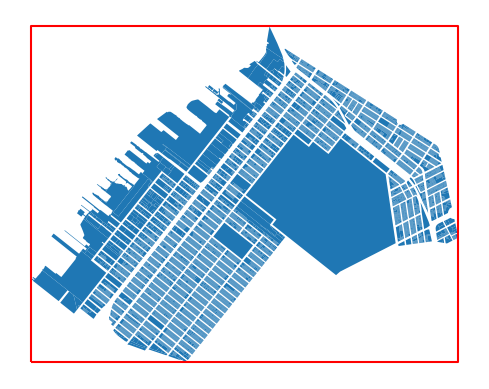

In [10]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="red").set_axis_off()

In [11]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [12]:
cb_307.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
bounds_poly.crs

In [14]:
bounds_poly.crs = cb_307.crs

In [15]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [16]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

<Axes: >

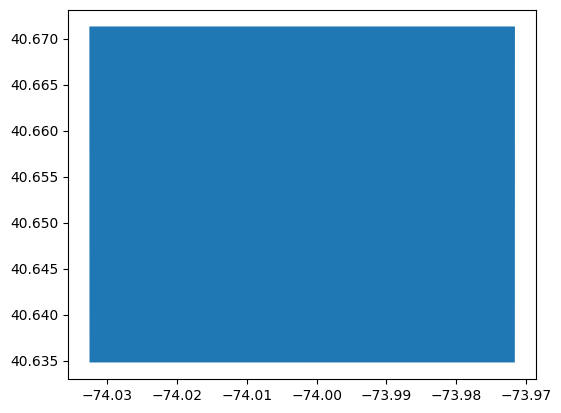

In [17]:
bounds_poly_wgs84.plot()

In [18]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/bldg_footprints/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

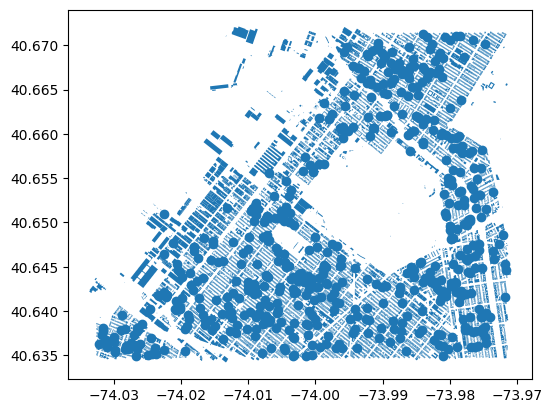

In [19]:
cb_307_bldgs.plot()

In [20]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

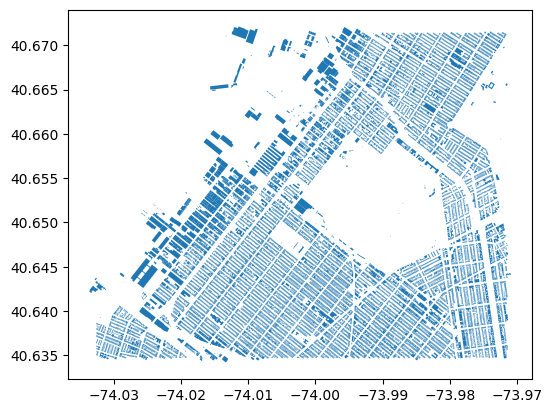

In [21]:
cb_307_bldgs.plot()

In [22]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

<Axes: >

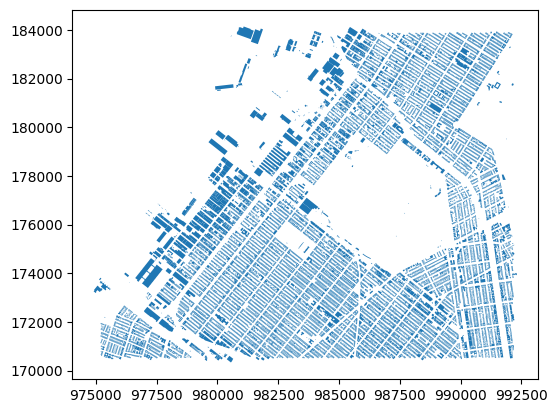

In [23]:
cb_307_bldgs.plot()

## spatial join


<Axes: >

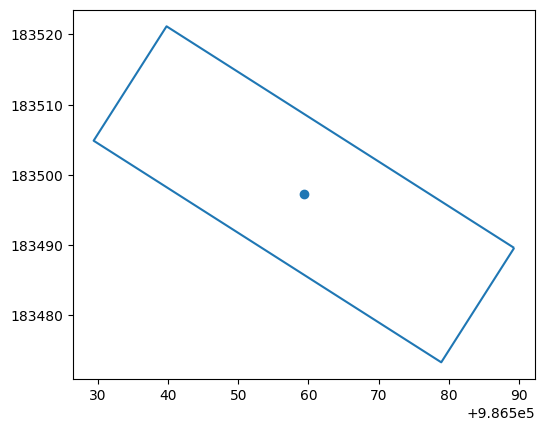

In [24]:
ss = cb_307_bldgs.sample()  # .plot()

ax = ss.boundary.plot()
ss.representative_point().plot(ax=ax)

In [25]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [26]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.122 182249.393, 989226....",POINT (989230.470 182235.219)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.250 173309.206, 989328....",POINT (989345.270 173325.920)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.261 170905.430, 976404....",POINT (976382.124 170892.831)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.817 170852.230, 975985....",POINT (975969.477 170848.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30108,None,3007280070,0.0,32.32698744,3007280070,2024,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},Constructed,2100,39,Photogramm,3424568,2024-05-06,1302014,0.0,"MULTIPOLYGON (((981341.775 176474.519, 981329....",POINT (981321.248 176478.339)
30109,None,3007280071,0.0,32.32698744,3007280071,2024,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},Constructed,2100,39,Photogramm,3424569,2024-05-06,1302015,0.0,"MULTIPOLYGON (((981352.745 176488.370, 981341....",POINT (981333.527 176493.843)
30110,None,3056280026,0.0,62.045557,3056280026,2024,{BFFCEC04-59C1-42BF-97DD-F15B73596D1A},Constructed,2100,56,Photogramm,3429745,2024-05-06,1302016,0.0,"MULTIPOLYGON (((986534.944 171176.810, 986476....",POINT (986498.863 171161.133)
30111,None,3008290016,0.0,50.0,3008290016,2023,{A2C9A5C4-FDE4-4561-911C-635B8593DC2B},Constructed,2100,41,Other (Man,3428542,2024-05-06,1300421,0.0,"MULTIPOLYGON (((978919.968 174549.012, 978952....",POINT (978917.743 174512.745)


In [27]:
cb_307_bldgs.shape[0]

30113

In [28]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(26357, 30113, 30113)

In [29]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.122 182249.393, 989226....",POINT (989230.470 182235.219)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.250 173309.206, 989328....",POINT (989345.270 173325.920)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.261 170905.430, 976404....",POINT (976382.124 170892.831)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.817 170852.230, 975985....",POINT (975969.477 170848.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30108,None,3007280070,0.0,32.32698744,3007280070,2024,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},Constructed,2100,39,Photogramm,3424568,2024-05-06,1302014,0.0,"MULTIPOLYGON (((981341.775 176474.519, 981329....",POINT (981321.248 176478.339)
30109,None,3007280071,0.0,32.32698744,3007280071,2024,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},Constructed,2100,39,Photogramm,3424569,2024-05-06,1302015,0.0,"MULTIPOLYGON (((981352.745 176488.370, 981341....",POINT (981333.527 176493.843)
30110,None,3056280026,0.0,62.045557,3056280026,2024,{BFFCEC04-59C1-42BF-97DD-F15B73596D1A},Constructed,2100,56,Photogramm,3429745,2024-05-06,1302016,0.0,"MULTIPOLYGON (((986534.944 171176.810, 986476....",POINT (986498.863 171161.133)
30111,None,3008290016,0.0,50.0,3008290016,2023,{A2C9A5C4-FDE4-4561-911C-635B8593DC2B},Constructed,2100,41,Other (Man,3428542,2024-05-06,1300421,0.0,"MULTIPOLYGON (((978919.968 174549.012, 978952....",POINT (978917.743 174512.745)


In [30]:
cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]]

,globalid,mpluto_bbl,rep_pt
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,POINT (979402.531 174638.900)
1,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},3010120038,POINT (989230.470 182235.219)
2,{454D03AE-5F41-4886-A5C5-74DD122005EF},3053130127,POINT (989345.270 173325.920)
3,{F02017F9-C56E-4793-96D1-03741F2569AC},3058710090,POINT (976382.124 170892.831)
4,{D97E7A81-466F-47F7-9159-D52052EC7129},3058850095,POINT (975969.477 170848.875)
...,...,...,...
30108,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},3007280070,POINT (981321.248 176478.339)
30109,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},3007280071,POINT (981333.527 176493.843)
30110,{BFFCEC04-59C1-42BF-97DD-F15B73596D1A},3056280026,POINT (986498.863 171161.133)
30111,{A2C9A5C4-FDE4-4561-911C-635B8593DC2B},3008290016,POINT (978917.743 174512.745)


In [31]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", op="within"
)

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
bldgs_w_lot

,globalid,mpluto_bbl,rep_pt,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,...,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,NumFloorsCluster,color
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,POINT (979402.531 174638.900),6880,BK,813,54,307,3002000,30020002002,...,None,24v1.1,None,40.646041,-74.017448,None,0.0,1756.742220,0,#ff0000
6,{6290F624-6A8D-482F-8BD9-57C27337D89F},3008370001,POINT (978532.245 174359.877),7179,BK,837,1,307,3002200,30022002000,...,None,24v1.1,None,40.645239,-74.020500,None,0.0,19141.495406,2,#800000
7,{F68D5818-C246-4828-A454-10D28962217D},3007890064,POINT (979672.912 175444.400),7747,BK,789,64,307,3002000,30020001003,...,None,24v1.1,None,40.648210,-74.016515,None,0.0,6152.697688,0,#ffff00
9,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},3052800064,POINT (989860.229 175412.619),12324,BK,5280,64,307,3050001,30500011001,...,None,24v1.1,None,40.648203,-73.979830,None,0.0,2138.490866,0,#ff00ff
11,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},3011150070,POINT (990278.753 178961.422),1061,BK,1115,70,307,3017100,30171002000,...,None,24v1.1,None,40.657928,-73.978234,None,0.0,2055.187662,0,#ff0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30106,{D5768C56-DC0C-4488-900C-B2A3A6D16F0D},3007280068,POINT (981296.529 176447.127),8156,BK,728,68,307,3008200,30082002003,...,None,24v1.1,None,40.650969,-74.010638,None,0.0,1031.523292,3,#ff0000
30107,{5621CB64-68C7-45BD-8999-B5A11F49E410},3007280069,POINT (981309.040 176462.804),8155,BK,728,69,307,3008200,30082002003,...,None,24v1.1,None,40.651013,-74.010592,None,0.0,1034.721967,3,#ff0000
30108,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},3007280070,POINT (981321.248 176478.339),8154,BK,728,70,307,3008200,30082002003,...,None,24v1.1,None,40.651054,-74.010548,None,0.0,1026.353733,3,#ff0000
30109,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},3007280071,POINT (981333.527 176493.843),8157,BK,728,71,307,3008200,30082002003,...,None,24v1.1,None,40.651100,-74.010502,None,0.0,1130.797708,3,#ff0000


In [33]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

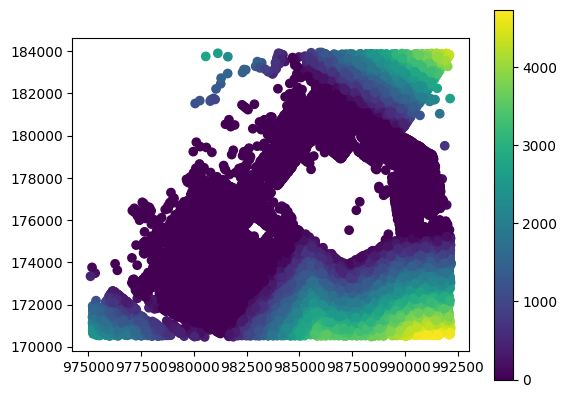

In [34]:
bldgs_w_lot_nearest.plot("distance", legend=True)

<Axes: >

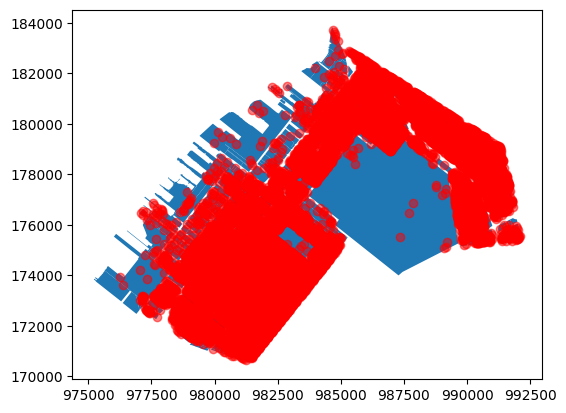

In [35]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [36]:
## drop cases where there is no match (i.e. no tax lot for buildings)

In [37]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [38]:
type(bldgs_w_lot)

pandas.core.frame.DataFrame

In [39]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

<Axes: >

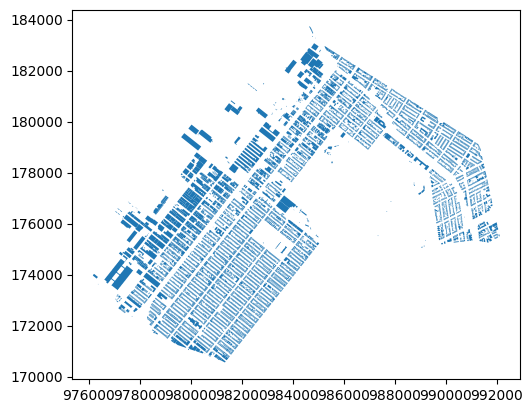

In [40]:
bldgs_w_lot_gdf.plot()

In [43]:
bldgs_w_lot_gdf

,globalid,mpluto_bbl_x,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,...,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,6880,BK,813,54,307,3002000,30020002002,20,...,Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,{6290F624-6A8D-482F-8BD9-57C27337D89F},3008370001,7179,BK,837,1,307,3002200,30022002000,22,...,Constructed,2100,36,Photogramm,3341882,2017-08-22,721766,0.0,"MULTIPOLYGON (((978615.393 174418.816, 978592....",POINT (978532.245 174359.877)
2,{F68D5818-C246-4828-A454-10D28962217D},3007890064,7747,BK,789,64,307,3002000,30020001003,20,...,Constructed,2100,32,Photogramm,3013180,2017-08-22,729838,0.0,"MULTIPOLYGON (((979722.511 175458.427, 979700....",POINT (979672.912 175444.400)
3,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},3052800064,12324,BK,5280,64,307,3050001,30500011001,500,...,Constructed,2100,62,Photogramm,3122680,2017-08-22,427739,0.0,"MULTIPOLYGON (((989834.116 175442.434, 989851....",POINT (989860.229 175412.619)
4,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},3011150070,1061,BK,1115,70,307,3017100,30171002000,171,...,Constructed,2100,147,Photogramm,3027391,2017-08-22,752842,0.0,"MULTIPOLYGON (((990301.650 178978.578, 990273....",POINT (990278.753 178961.422)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14310,{D5768C56-DC0C-4488-900C-B2A3A6D16F0D},3007280068,8156,BK,728,68,307,3008200,30082002003,82,...,Constructed,2100,39,Photogramm,3424566,2024-05-06,1302012,0.0,"MULTIPOLYGON (((981317.242 176443.542, 981304....",POINT (981296.529 176447.127)
14311,{5621CB64-68C7-45BD-8999-B5A11F49E410},3007280069,8155,BK,728,69,307,3008200,30082002003,82,...,Constructed,2100,39,Photogramm,3424567,2024-05-06,1302013,0.0,"MULTIPOLYGON (((981329.669 176459.233, 981317....",POINT (981309.040 176462.804)
14312,{7B705FF4-ACD6-45CD-A2E0-C32B7F74C263},3007280070,8154,BK,728,70,307,3008200,30082002003,82,...,Constructed,2100,39,Photogramm,3424568,2024-05-06,1302014,0.0,"MULTIPOLYGON (((981341.775 176474.519, 981329....",POINT (981321.248 176478.339)
14313,{75A668C9-C3C1-4D26-A670-0BD6A433B4BB},3007280071,8157,BK,728,71,307,3008200,30082002003,82,...,Constructed,2100,39,Photogramm,3424569,2024-05-06,1302015,0.0,"MULTIPOLYGON (((981352.745 176488.370, 981341....",POINT (981333.527 176493.843)


In [44]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [45]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [46]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [47]:
bldgs_w_lot_gdf.LandUse.unique()

array(['One & Two Family Buildings', 'Public Facilities & Institutions',
       'Industrial & Manufacturing',
       'Mixed Residential & Commercial Buildings',
       'Commercial & Office Buildings', 'Multi-Family Walk-Up Buildings',
       'Transportation & Utility', 'Parking Facilities', 'Unknown',
       'Multi-Family Elevator Buildings', 'Vacant Land',
       'Open Space & Outdoor Recreation'], dtype=object)

In [ ]:
bldgs_w_lot_gdf["LandUse"].fillna("Unknown", inplace=True)

In [ ]:
bldgs_w_lot_gdf[["color", "LandUse"]]

In [ ]:
cmap_rgb

In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [ ]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

In [ ]:
cb_307.columns

In [ ]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

In [ ]:
cb_307.BBL

In [ ]:
cb_307_bldgs.mpluto_bbl

In [ ]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [ ]:
cb_307_bldgs.mpluto_bbl

In [ ]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [ ]:
bldgs_w_lot_attrib

In [ ]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

In [ ]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [ ]:
table1: 14315
table2: 14318

In [ ]:
bldgs_w_lot_gdf.globalid

In [ ]:
bldgs_w_lot_attrib[
    bldgs_w_lot_attrib.globalid.eq("{D5768C56-DC0C-4488-900C-B2A3A6D16F0D}")
]

In [ ]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [ ]:
len(missing_buildings)

In [ ]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [ ]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

In [ ]:
bldgs_w_lot_attrib  # .set_geometry("geometry", inplace=True)

### investigate- what's going on??


In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [ ]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

In [ ]:
cb_307_by_owner

In [ ]:
cb_307_by_owner.sort_values("LotArea", ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [ ]:
cb_307_by_owner

## Intersect / Difference


In [ ]:
sample_block = cb_307.Block.sample(1).values[0]

In [ ]:
sample_block

In [ ]:
cb_307_bldgs.columns

In [ ]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [ ]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

In [ ]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [ ]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [ ]:
sample_block_non_bldg.shape

In [ ]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [ ]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [ ]:
sample_block_non_bldg_intersect.shape

In [ ]:
sample_block_non_bldg_intersect.plot()

## Union


In [ ]:
sample_block_lots.shape

In [ ]:
sample_block_lots["lot_area"] = sample_block_lots.area

In [ ]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

In [ ]:
lots_bldgs_union.shape

In [ ]:
import pandas as pd

In [ ]:
lots_bldgs_union

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [ ]:
lots_bldgs_union.globalid.unique()

In [ ]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

In [ ]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [ ]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [ ]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

In [ ]:
cb_307["soft_site"].value_counts()

In [ ]:
cb_307.plot("soft_site", legend=True)

In [ ]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]